------------------------------------------------------
***Sergio Aizcorbe - 100406602***

***Bernardo Bouzas - 100406634***

------------------------------------------------------

# Lab 4 (Part 2): Character-Level LSTM in PyTorch


------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------


In this notebook, construct a character-level LSTM with PyTorch. The network will train character by character on some text, then generate new text character by character. As an example, I will train on Anna Karenina. **This model will be able to generate new text based on the text from the book!**

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn). Below is the general architecture of the character-wise RNN.


In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "http://karpathy.github.io/assets/rnn/charseq.jpeg", width=500, height=400)

First let's load in our required resources for data loading and model creation.

In [2]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' #High quality figures

sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 8)

## Part I. Load in Data

First, we load the Anna Karenina text file and convert it into integers for our network to use. 

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# open text file and read in data as `text`
with open('anna.txt', 'r') as f:
    text = f.read()

Let's check out the first 100 characters, make sure everything is peachy. According to the [American Book Review](http://americanbookreview.org/100bestlines.asp), this is the 6th best first line of a book ever.

In [5]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

### Tokenization

In the cells, below, I'm creating a couple **dictionaries** to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

Your can read more about Python **set data types** in this [link](https://docs.python.org/3.8/library/stdtypes.html#set-types-set-frozenset). Also, check [here](http://book.pythontips.com/en/latest/enumerate.html) about the `enumerate()` Python built-in function.

In [6]:
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))             #set() is an unordered collection of unique elements in text
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

And we can see those same characters from above, encoded as integers.

In [7]:
encoded[:100]

array([29, 69, 15, 20, 51, 26, 13, 63, 33, 38, 38, 38, 53, 15, 20, 20, 60,
       63, 11, 15, 32, 30, 82, 30, 26, 34, 63, 15, 13, 26, 63, 15, 82, 82,
       63, 15, 82, 30, 21, 26, 19, 63, 26,  9, 26, 13, 60, 63, 74,  3, 69,
       15, 20, 20, 60, 63, 11, 15, 32, 30, 82, 60, 63, 30, 34, 63, 74,  3,
       69, 15, 20, 20, 60, 63, 30,  3, 63, 30, 51, 34, 63, 78, 46,  3, 38,
       46, 15, 60, 68, 38, 38, 44,  9, 26, 13, 60, 51, 69, 30,  3])

In [8]:
n_labels = len(chars)

## Part II. Pre-processing the data

As you can see in our char-RNN image above, our LSTM expects an input that is **one-hot encoded** meaning that each character is converted into an integer (via our created dictionary) and *then* converted into a column vector where only it's corresponding integer index will have the value of 1 and the rest of the vector will be filled with 0's. Since we're one-hot encoding the data, let's make a function to do that!


In [9]:
def one_hot_encode(arr, n_labels):
    
    num_elements = arr.shape[0]*arr.shape[1]
    
    # Initialize the the encoded array
    one_hot = np.zeros([num_elements, n_labels], dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.reshape([num_elements])] = 1.
    
    # Reshape as (n_batch,seq_length,n_labels)
    
    return one_hot.reshape(arr.shape[0],arr.shape[1],n_labels)

In [10]:
# check that the function works as expected
test_seq = np.array([[3, 5, 1],[2,4,6]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]]]


## Part III. Making training mini-batches


To train on this data, we also want to create mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this.

In [11]:
Image(url= "http://digtime.cn/uploads/images/201907/12/1/Tt94B4Htu7.png", width=700, height=450)

In this example, we'll take the encoded characters (passed in as the `arr` parameter) and split them into multiple sequences, given by `batch_size`. Each of our sequences will be `seq_length` long.

### Creating Batches

**1. The first thing we need to do is discard some of the text so we only have completely full mini-batches. **

Each batch contains $N \times M$ characters, where **$N$ is the batch size** (the number of sequences in a batch) and $M$ is the seq_length or number of time steps in a sequence. Then, to get the total number of batches, $K$, that we can make from the array `arr`, you divide the length of `arr` by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from `arr`, $N * M * K$.

**2. After that, we need to split `arr` into batches. ** 

You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences in a batch, so let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$.

**3. Now that we have this array, we can iterate through it to get our mini-batches. **

The idea is each batch is a $N \times M$ window on the $N \times (M * K)$ array. For each subsequent batch, the window moves over by `seq_length`. We also want to create both the input and target arrays. Remember that the targets are just the inputs shifted over by one character. 

> **Exercise:** Understand the following code for creating batches in the function below. **Note:** Take a look to this [link](https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do) to understand what `yield` does.

In [12]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))      # IMPORTANT TO UNDERSTAND THE DIMENSIONS OF arr
    
    # iterate through the array. We read every of the n_batches sequeces in windows of seq_length characters
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        
        if (n+seq_length<arr.shape[1]):     
            y[:,-1] = arr[:, n+seq_length]
            y[:, :-1] = x[:, 1:]
        else: # If n+seq_length == arr.shape[1], then we are done! (arr[:, n+seq_length] yields an indexing error).
              # We return a window with one column less (as the target for the last character is not available)
            x = arr[:, n:n+seq_length-1]
            y = np.zeros_like(x)
            y[:, :-1] = x[:, 1:]
            y[:,-1] = arr[:,-1]            
        yield x, y

### Test Your Implementation

Lets make some data sets and we can check out what's going on as we batch data. Here, as an example, I'm going to use a batch size of 8 and 50 sequence steps.

In [13]:
batches = get_batches(encoded, 8, 50)
x,y = next(batches)
print(x.shape)
print(y.shape)

(8, 50)
(8, 50)


In [14]:
# printing out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[29 69 15 20 51 26 13 63 33 38]
 [34 78  3 63 51 69 15 51 63 15]
 [26  3 22 63 78 13 63 15 63 11]
 [34 63 51 69 26 63 17 69 30 26]
 [63 34 15 46 63 69 26 13 63 51]
 [17 74 34 34 30 78  3 63 15  3]
 [63 43  3  3 15 63 69 15 22 63]
 [73 49 82 78  3 34 21 60 68 63]]

y
 [[69 15 20 51 26 13 63 33 38 38]
 [78  3 63 51 69 15 51 63 15 51]
 [ 3 22 63 78 13 63 15 63 11 78]
 [63 51 69 26 63 17 69 30 26 11]
 [34 15 46 63 69 26 13 63 51 26]
 [74 34 34 30 78  3 63 15  3 22]
 [43  3  3 15 63 69 15 22 63 34]
 [49 82 78  3 34 21 60 68 63 27]]


The above output should look something like 
```
x
 [[25  8 60 11 45 27 28 73  1  2]
 [17  7 20 73 45  8 60 45 73 60]
 [27 20 80 73  7 28 73 60 73 65]
 [17 73 45  8 27 73 66  8 46 27]
 [73 17 60 12 73  8 27 28 73 45]
 [66 64 17 17 46  7 20 73 60 20]
 [73 76 20 20 60 73  8 60 80 73]
 [47 35 43  7 20 17 24 50 37 73]]

y
 [[ 8 60 11 45 27 28 73  1  2  2]
 [ 7 20 73 45  8 60 45 73 60 45]
 [20 80 73  7 28 73 60 73 65  7]
 [73 45  8 27 73 66  8 46 27 65]
 [17 60 12 73  8 27 28 73 45 27]
 [64 17 17 46  7 20 73 60 20 80]
 [76 20 20 60 73  8 60 80 73 17]
 [35 43  7 20 17 24 50 37 73 36]]
 ```
 although the exact numbers may be different. Check to make sure the data is shifted over one step for `y`.

---
## Part IV. Defining the network with PyTorch

Below is where you'll define the network.

In [15]:
Image(url= "http://digtime.cn/uploads/images/201907/12/1/ZG9JIjidmz.png", width=500, height=400)

#### Model Structure

In `__init__` the suggested structure is as follows:
* Create and store the necessary dictionaries 
* Define an LSTM layer that takes as params: an input size (the number of characters), a hidden layer size `n_hidden`, a number of layers `n_layers`, a dropout probability `drop_prob`, and a batch_first boolean (True, since we are batching)
* Define a dropout layer with `drop_prob`
* Define a fully-connected layer with params: input size `n_hidden` and output size (the number of characters)
* Finally, initialize LSTM hidden state (h_0) and memory (c_0)


#### LSTM Inputs/Outputs

You can create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, num_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. And we can add dropout by adding a dropout parameter with a specified probability; this will automatically add dropout to the inputs or outputs. 


> **Exercise:** Complete the following code


In [16]:
class CharLSTM(nn.Module):
    
    def __init__(self, chars, hidden_dim=256, n_layers=2, drop_prob=0.5):
        
        ''' n_chars is the number of different characters '''        
        
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.chars = chars
        self.n_char = len(chars)
        
        ## TODO: define the LSTM. Do not forget to include the dropout between LSTM layers!
        self.lstm = nn.LSTM(
            input_size=self.n_char, 
            hidden_size=self.hidden_dim, 
            num_layers=self.n_layers, 
            dropout=self.drop_prob, 
            batch_first=True
        )
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(p=drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(
            in_features=self.hidden_dim, 
            out_features=self.n_char
        )
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
      
    
    def forward(self, x, h=None):
        ''' Forward pass through the network. 
            These inputs are x, and the LSTM initial hidden/cell state h. 
            When h is not provided, default initializaiton (all zeros) is used.'''
        
        if (h==None):
            #No initial hidden_state and memory are provided. They are set to 0s
            r_output, hidden = self.lstm(x)  
        
        else:
            #Non-zero initial state. This is used for generating new text
            r_output, hidden = self.lstm(x,h)     
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs
        out = out.reshape(-1, self.hidden_dim) 

        ## TODO: put x through the fully-connected layer and a logsoftmax output       
        out = self.logsoftmax(self.fc(out))

        # return the final output and the hidden state
        return out, hidden
    

The following code extends the above class by including a training method, and also the methods to perform one-hot encoding and get the mini-batches from the text. A couple of details about training: 
* Within the batch loop, we detach the hidden state from its history; this time setting it equal to a new *tuple* variable because an LSTM has a hidden state that is a tuple of the hidden and cell states.
* We use [`clip_grad_norm_`](https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html) to help prevent exploding gradients.

> **Exercise:** Complete the following code


In [ ]:
class CharLSTM_extended(CharLSTM):
    
    def __init__(self, batch_size, sequence_length,
                 epochs=5, lr=0.001, clip=5, *args, **kwargs):
        
        super().__init__(*args, **kwargs)  

        self.batch_size = batch_size
        
        self.clip = clip
        
        self.seq_length = sequence_length
        
        self.lr = lr #Learning Rate
    
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        
        # Setting GPU training if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
        # Training mode by default
        self.train()
        
    def get_batches(self,arr):
        '''Create a generator that returns batches of size
           batch_size x seq_length from arr.

           Arguments
           ---------
           arr: Array you want to make batches from
           self.batch_size: Batch size, the number of sequences per batch
           self.seq_length: Number of encoded chars in a sequence
        '''
        
        
        batch_size_total = self.batch_size * self.seq_length
        # total number of batches we can make
        n_batches = len(arr)//batch_size_total
        
        # Keep only enough characters to make full batches
        arr = arr[:n_batches * batch_size_total]
        # Reshape into batch_size rows
        arr = arr.reshape((self.batch_size, -1))      # IMPORTANT TO UNDERSTAND THE DIMENSIONS OF arr
        
        # iterate through the array. We read every of the n_batches sequeces in windows of seq_length characters
        for n in range(0, arr.shape[1], self.seq_length):
            # The features
            x = arr[:, n:n+self.seq_length]
            # The targets, shifted by one
            y = np.zeros_like(x)
            
            if (n+self.seq_length<arr.shape[1]):     
                y[:,-1] = arr[:, n+self.seq_length]
                y[:, :-1] = x[:, 1:]
            else: # If n+seq_length == arr.shape[1], then we are done! (arr[:, n+seq_length] yields an indexing error).
                # We return a window with one column less (as the target for the last character is not available)
                x = arr[:, n:n+self.seq_length-1]
                y = np.zeros_like(x)
                y[:, :-1] = x[:, 1:]
                y[:,-1] = arr[:,-1]            
            yield x, y
            
    def one_hot_encode(self, arr):
    
        num_elements = arr.shape[0]*arr.shape[1]
        
        # Initialize the the encoded array
        one_hot = np.zeros([num_elements, self.n_char], dtype=np.float32)
        
        # Fill the appropriate elements with ones
        one_hot[np.arange(one_hot.shape[0]), arr.reshape([num_elements])] = 1.
        
        # Reshape as (n_batch,seq_length,n_labels)
        return one_hot.reshape(arr.shape[0], arr.shape[1], self.n_char)
    
    def trainloop(self,encoded_text):
        
        for e in range(self.epochs):
            counter = 0.
            start_time = time.time()
            running_loss = 0.
            
            for x, y in self.get_batches(encoded_text):
                
                counter += 1.
                
                # One-hot encode our data and make them Torch tensors
                x = self.one_hot_encode(x)

                x, y = torch.from_numpy(x).to(self.device), torch.from_numpy(y).to(self.device)
                
                # TO DO: reset gradients 
                self.optim.zero_grad() 
                
                # TO DO: compute output
                out,hid = self.forward(x)
                

                # Calculate the loss and perform backprop
                loss = self.criterion(out, y.reshape([out.shape[0],])) 
                # TO DO: compute gradients
                loss.backward()
                
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), self.clip)
                
                self.optim.step() 
                
                running_loss += loss.item()
                
            self.loss_during_training.append(running_loss/counter)
            
            if(e % 1 == 0): 
                print("Epoch %d. Training loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],(time.time() - start_time)))            


In [18]:
my_charLSTM = CharLSTM_extended(
    batch_size=128,
    sequence_length=100,
    chars=chars,
    epochs=10,
    hidden_dim=512,
    n_layers=2,
    drop_prob=0.3
)

In [19]:
my_charLSTM.trainloop(encoded)

RuntimeError: Expected object of scalar type Long but got scalar type Int for argument #2 'target' in call to _thnn_nll_loss_forward

## Part V. Getting the best model

To set your hyperparameters to get the best performance, you'll want to watch the training and validation losses. If your training loss is much lower than the validation loss, you're overfitting. Increase regularization (more dropout) or use a smaller network. If the training and validation losses are close, you're underfitting so you can increase the size of the network.

> **Exercise:** 
> - Separate the text intro training text and validation text.
> - Modify the class CharLSTM_extended that monitors the validation loss during training
> - Save your model after every epoch (save the parameters in a different file for every epoch). To do so, include a method in the class to save the model parameters. Then, you call it after the end of every epoch.
> - Perform early stopping. I.e., load the parameters of the last epoch in which validation loss was decreasing.

Here's some good advice from [Andrej Karpathy](https://github.com/karpathy/char-rnn#tips-and-tricks) on training the network.

In order to save at every epoch, the following code can help. Here we are saving the parameters needed to create the same architecture, the hidden layer hyperparameters and the text characters.

```python

# change the name, for saving multiple files
model_name = 'rnn_' + str(e) + '_epoch.net'

checkpoint = {'hidden_dim': my_charLSTM.hidden_dim,
              'n_layers': my_charLSTM.n_layers,
              'batch_size': my_charLSTM.batch_size,
              'sequence_length': my_charLSTM.seq_length,
              'state_dict': my_charLSTM.state_dict(),
              'chars': my_charLSTM.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)
```

Then, if you want to restore your model, you can use the following code

```python

# Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
with open('rnn_20_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharLSTM_extended(batch_size=checkpoint['batch_size'],seq_length=checkpoint['seq_length'], 
                           chars=checkpoint['chars'],
                           hidden_dim=checkpoint['hidden_dim'], 
                           n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])
```


In [324]:
class CharLSTM_extended_val(CharLSTM_extended):
    
    def __init__(self, *args, **kwargs):

        super().__init__(*args, **kwargs)        
        self.loss_during_validation = [] 
        
        # Training mode by default
        self.train()
    
    def trainloop(self, encoded_text, validation):
        
        for e in range(self.epochs):
            
            counter = 0.
            start_time = time.time()
            running_loss = 0.
            
            for x, y in self.get_batches(encoded_text):
                
                counter += 1.
                
                # One-hot encode our data and make them Torch tensors
                x = self.one_hot_encode(x)

                x, y = torch.from_numpy(x).to(self.device), torch.from_numpy(y).to(self.device)
                
                # TO DO: reset gradients 
                self.optim.zero_grad()

                # TO DO: compute output
                out, _ = self.forward(x.view(self.batch_size))

                # Calculate the loss and perform backprop
                loss = self.criterion(out, y.reshape([out.shape[0],])) 
            
                # TO DO: compute gradients
                loss.backward()

                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), self.clip)
                
                self.optim.step() 
                
                running_loss += loss.item()
                
            self.loss_during_training.append(running_loss/counter)

            #validation
            self.eval()
            with torch.no_grad():
                for x, y in self.get_batches(validation):
                    counter += 1.
                    
                    # One-hot encode our data and make them Torch tensors
                    x = self.one_hot_encode(x)

                    x, y = torch.from_numpy(x).to(self.device), torch.from_numpy(y).to(self.device)

                    # TO DO: compute output
                    out, _ = self.forward(x)

                    # Calculate the loss
                    loss = self.criterion(out, y.reshape([out.shape[0],])) 
                    
                    running_loss += loss.item()            
            
            self.loss_during_validation.append(running_loss/counter)

            model_name = 'rnn_' + str(e) + '_epoch.net'
 
            checkpoint = {
                'hidden_dim': self.hidden_dim,
                'n_layers': self.n_layers,
                'batch_size': self.batch_size,
                'sequence_length': self.seq_length,
                'state_dict': self.state_dict(),
                'chars': self.n_char
            }
            with open(model_name, 'wb') as f:
                torch.save(checkpoint, f)

            if(e % 1 == 0): 
                print("Epoch %d. Training loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],(time.time() - start_time)))            


In [325]:
i_validation = int(len(encoded)*0.7)
trainset, validset = encoded[:i_validation], encoded[i_validation:]

In [326]:
my_charLSTM = CharLSTM_extended_val(
    batch_size=128,
    sequence_length=100,
    chars=chars,
    epochs=5,
    hidden_dim=512,
    n_layers=2,
    drop_prob=0.3
)

In [298]:
my_charLSTM.trainloop(trainset,validset)

RuntimeError: Expected object of scalar type Long but got scalar type Int for argument #2 'target' in call to _thnn_nll_loss_forward

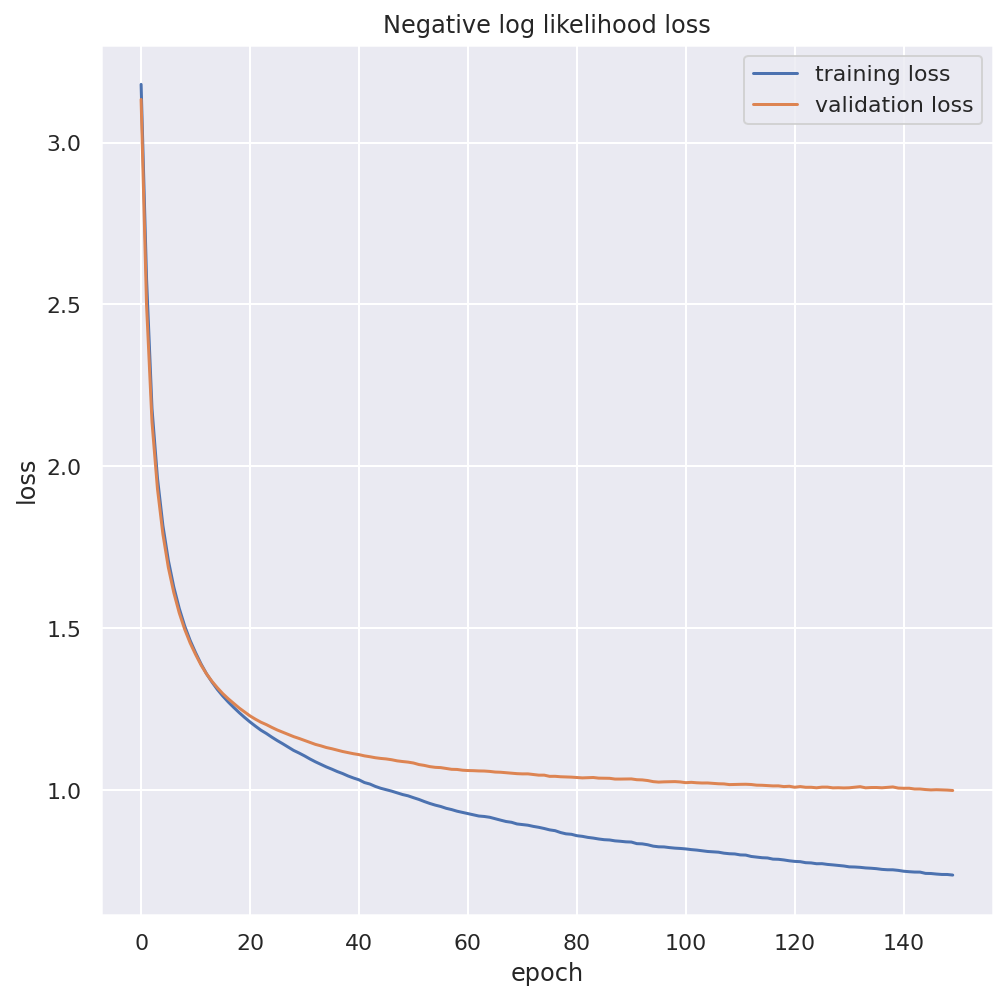

In [55]:
plt.plot(
    range(my_charLSTM.epochs),
    my_charLSTM.loss_during_training,
    label = 'training loss'
)
plt.plot(
    range(my_charLSTM.epochs),
    my_charLSTM.loss_during_validation,
    label = 'validation loss'
)
plt.legend()
plt.title('Negative log likelihood loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
i_validation = int(len(encoded)*0.8)
trainset, validset = encoded[:i_validation], encoded[i_validation:]

In [ ]:
my_charLSTM = CharLSTM_extended_val(
    batch_size=128,
    sequence_length=100,
    chars=chars,
    epochs=30,
    hidden_dim=512,
    n_layers=2,
    drop_prob=0.3,
    savename = 'lstm'
)

In [ ]:
my_charLSTM.trainloop(trainset,validset)

In [ ]:
def n_paramenters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params
len(encoded)

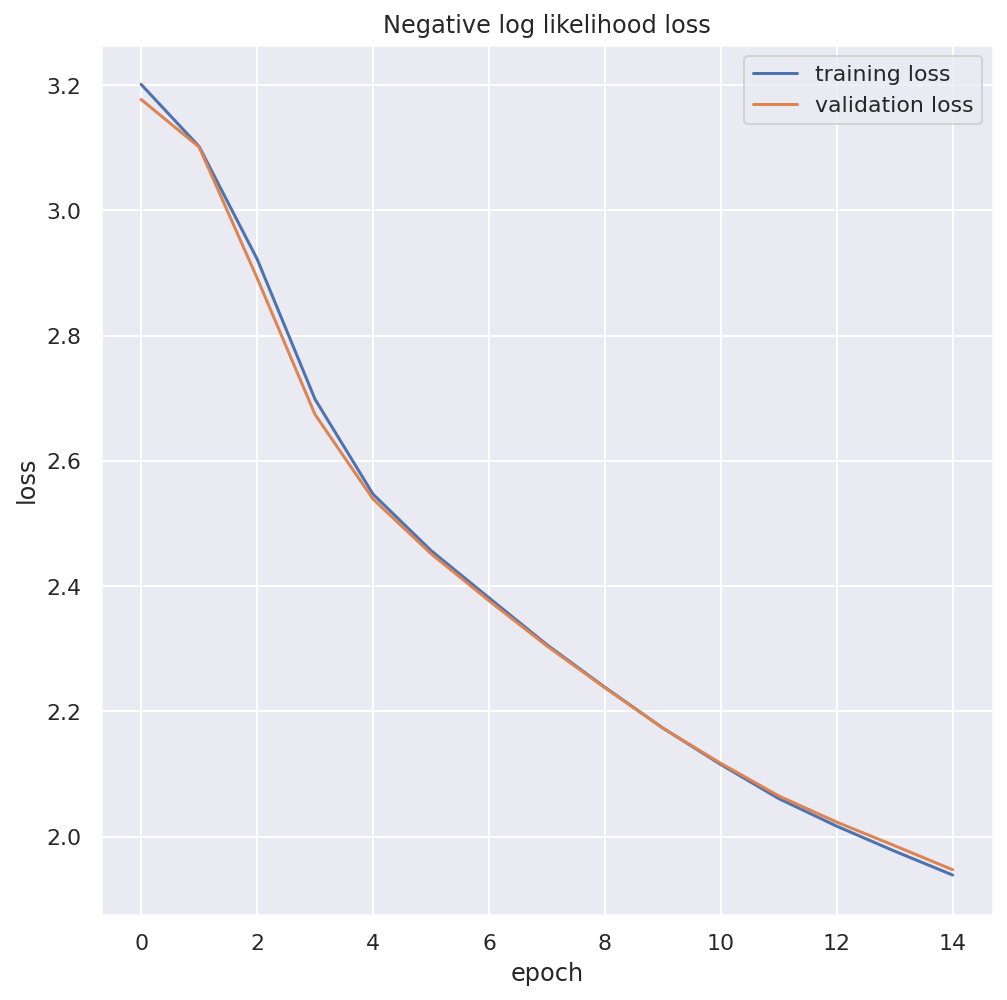

In [87]:
plt.plot(
    range(my_charLSTM.epochs),
    my_charLSTM.loss_during_training,
    label='training loss'
)
plt.plot(
    range(my_charLSTM.epochs),
    my_charLSTM.loss_during_validation,
    label='validation loss'
)
plt.legend()
plt.title('Negative log likelihood loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

---
## Part VI. Making Predictions

Now that the model is trained, we'll want to sample from it and make predictions about next characters! To sample, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and get another predicted character. Just keep doing this and you'll generate a bunch of text!

### A note on the `predict`  function

The output of our RNN is from a fully-connected layer followed by a Softmax layer, and it outputs a **distribution of next-character scores**.

### Top K sampling

Our predictions come from a categorical probability distribution over all the possible characters. We can make the sample text and make it more reasonable to handle (with less variables) by only considering some $K$ most probable characters. This will prevent the network from giving us completely absurd characters while allowing it to introduce some noise and randomness into the sampled text. Read more about [topk, here](https://pytorch.org/docs/stable/torch.html#torch.topk).

> **Exercise:** Complete the following code

In [88]:
def predict(charLSTM_class, current_char, dict_c2int, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[char2int[current_char]]])
        x = charLSTM_class.one_hot_encode(x)
        
        inputs = torch.from_numpy(x)
        
        charLSTM_class.to('cpu')
    
        # TO DO: get the output of the model
        
        out, h = charLSTM_class.forward(inputs) #YOUR CODE HERE

        p, top_ch = torch.exp(out).topk(top_k)
        top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.detach().numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return int2char[char], h

### Generating text from an initial string

Typically you'll want to prime the network so you can build up a hidden state. Otherwise the network will start out generating characters at random. In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

> **Exercise:** Understand the following code! Nothing to do

In [89]:
def sample(charLSTM_class, size, dict_c2int, prime='The', top_k=5):
    
    charLSTM_class.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = None
    for ch in prime:
        char, h = predict(charLSTM_class, ch, char2int, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(charLSTM_class, chars[-1], char2int, h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

Finally, lets take a look to the text that our model generates

In [90]:
print(sample(my_charLSTM, 1000, char2int, prime='Anna', top_k=5))

Annan ared anghashorithe onghe antheret thid adorothost hit anethous son at shan arin hentheroure st t hithathantit h hither soun hon thed the t an shetot hot thed t asothouthadithidose thishist andin he sone on athisoun shin h th hare ot oson ad oshe ten tin toshenthand othedontose an osoton othinthe he ashar thig t anthid se stid orere ashot thit t sharon s atore ang h an tonthit had that sot onghed het thangedothone he athe and an sot tharine tid thine tothothe he an thand hathind sh outhe athe arotothin heron thindoran henghed ated tharare and are tont s asothithe sed therid at sh tothote and on s oshe atothaset and tou hour otothe hin hed the t s oshedid arin hot he son t at ton an ouras han ther tit hin t os ad hase the t asthine torin he thed soushedisotontisoretoten therosothe thanerous anend aron sotourarontot hitheritond ad s thanet than t on on toserin t osthe s teronerorotitos hinder tingithotid an otound ashan storind thand
arad
ared herithe s thin ont shethe se t an h ond

In [100]:
with open('rnn_50_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
 
loaded = CharLSTM_extended_val(
    batch_size=checkpoint['batch_size'],
    sequence_length=checkpoint['sequence_length'], 
    chars=chars,
    hidden_dim=checkpoint['hidden_dim'], 
    n_layers=checkpoint['n_layers']
)
loaded.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [101]:
print(sample(loaded, 1000, char2int, prime='Anna', top_k=5))

Annathe shile s t the are t ant whe ate his hede tere tofe sthed as sth an whe t wasthont thand s anthe wathanend hine t hede tore wand thasitond
hant the win he stind s and athin ato the wo an s s atoules t thathis wasit wars he hant atershe t herourithe tor ashe he his herishe s thin tes shite wanged the s ashes the hand ser s ane thily, s simere thim se at harend se wang ther t anditong he t th anede wato and
and ared wes th hand sthas he wind we thed touloro thintouthe s the tinthand ad thong s sed

ad an t t ad tithind s the sind s ande hine as the we t hase washashed an and sthe are hine hin wathim thate to wis shen hore tin we tent ad wous tind ars the hen to he ang harer andint hito sthithan t he t hestonerof antil th withed witengero then t s wang and the an hant tes ang th athor heste hese at th t sene te ad tilesine he wate st thatout thimime tis tise hand stingherst sten torondim t hero thiton serouthent aste t hit h thin he anted hisimed whan thatonges se stherered s s hit

In [96]:
print(sample(loaded, 1000, char2int, prime='Anna', top_k=5))

Annant ad t the ad as and wout ar has waresthorese sitonthedery anghe thar t he to war t t wiled, him sed witofe hing, atout thend, tin whare athedere an wed thintime she thofered the thenteng heder s t t andithasthe win at time wangest an sheryoulis hin sis wat athang, tilled tond athan t t wind hede thind athith s wared arer t werer than he hery wilin the tisthe time thas sesin the toned the t thisimon hinge withonede an thend thit sthed


"
are t s wan ane ant won ses ath ad an wand anede he had wer sh thille tithar sested withe te heres hang, s atheredisthengoulingore ad wathe adimasend he th an and ar the he har at he watontoun t an he s st win atin he we tenger asind tis s tof st thantound, st ashar ater are was he ad at tisilis won athinthe he sthed t teng as t tithimoreder theringhenges wind s at haredind,"Whare hisilesinthere and s an t hed hat hilested te wand theshand horimadithe sing simered hinere s arind h an tind s wand thisthad,"Ninge ang, to ange whe whimit hil t t hed